In [1]:
import pandas as pd
import vaex as vx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
#fonte:https://covid.saude.gov.br/
data = pd.read_csv("covid.csv", sep=';')
data['data']= pd.to_datetime(data['data'], format='%Y/%m/%d')

In [3]:
#Casos por dia em todo o Brasil
df = data[data['regiao']=='Brasil'][['data','casosNovos','semanaEpi']]
df.head()

,data,casosNovos,semanaEpi
0,2020-02-25,0,9
1,2020-02-26,1,9
2,2020-02-27,0,9
3,2020-02-28,0,9
4,2020-02-29,1,9


Preparando variáveis para treinamento do modelo preditivo

In [4]:
#Coluna com casos do dia anterior(diaAnt) e coluna com a diferença entre casosNovos e diaAnt(Aumentou ou diminuiu? Quanto?)
df['diaAnt']=df.groupby(['semanaEpi'])['casosNovos'].shift()
df['diaDif']=df.groupby(['semanaEpi'])['diaAnt'].diff().fillna(0)
df=df.dropna()
df.head()

,data,casosNovos,semanaEpi,diaAnt,diaDif
1,2020-02-26,1,9,0.0,0.0
2,2020-02-27,0,9,1.0,1.0
3,2020-02-28,0,9,0.0,-1.0
4,2020-02-29,1,9,0.0,0.0
6,2020-03-02,0,10,0.0,0.0


# Treinamento

In [5]:
train = df[df['data']<'2020-12-01']
test = df[df['data']>'2020-11-30']

In [6]:
x = train[['diaAnt','diaDif']]
y = train['casosNovos']
t = test[['diaAnt','diaDif']]

In [7]:
m = LinearRegression()
m.fit(x, y)
p = m.predict(t)

In [8]:
error = mean_squared_log_error(test['casosNovos'], p)
error

3.139619740092399

In [9]:
val = test.copy()
val['casosNovos'] = p
val.head()

,data,casosNovos,semanaEpi,diaAnt,diaDif
280,2020-12-01,23676.009239,49,21138.0,-3330.0
281,2020-12-02,47943.549713,49,50909.0,29771.0
282,2020-12-03,49382.196469,49,49863.0,-1046.0
283,2020-12-04,49771.754944,49,50434.0,571.0
284,2020-12-05,46891.445287,49,46884.0,-3550.0


# Visualização

Conforme apresentado nos gráficos, o modelo foi capaz de prever valores bem próximos aos originais.

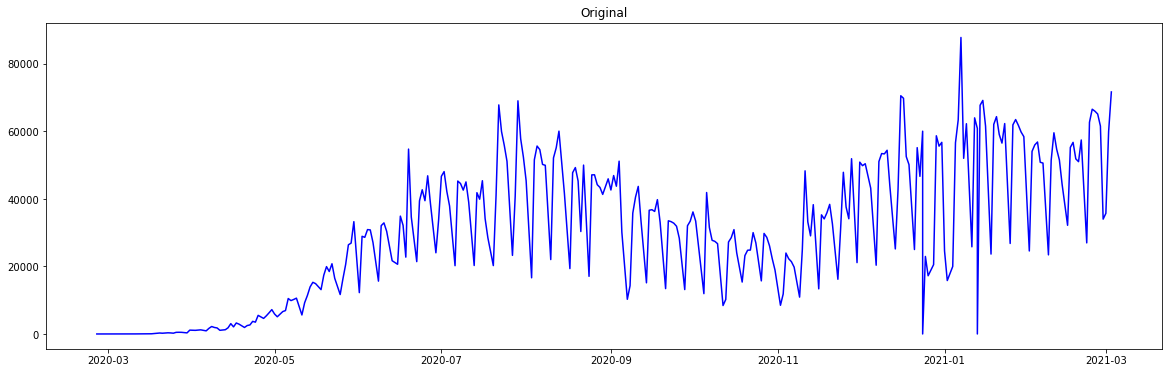

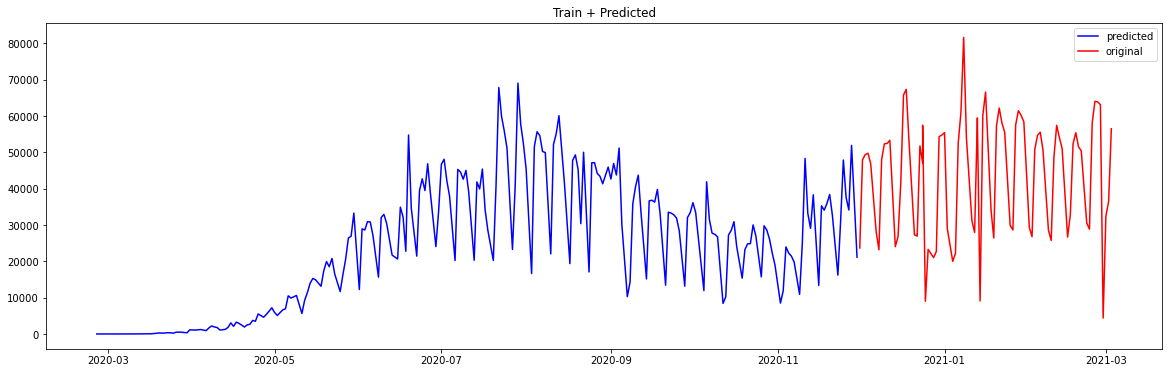

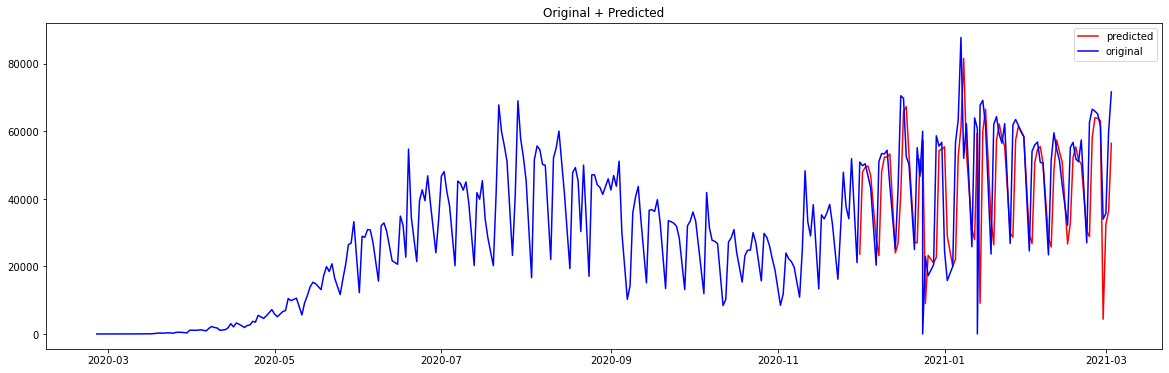

In [10]:
#Valores originais
plt.figure(figsize=(20,6))
plt.title('Original')
plt.plot(df['data'], df['casosNovos'],color='b');
plt.show()
#Valores de treinamento + valores preditos
plt.figure(figsize=(20,6))
plt.title('Train + Predicted')
plt.plot(train['data'], train['casosNovos'],color='b')
plt.plot(val['data'], val['casosNovos'],color='r')
plt.legend(['predicted','original'])
plt.show()
#Valores preditos sobrepostos aos valores originais
plt.figure(figsize=(20,6))
plt.title('Original + Predicted')
plt.plot(val['data'], val['casosNovos'],color='r')
plt.plot(df['data'], df['casosNovos'],color='b')
plt.legend(['predicted','original'])
plt.show()


In [11]:
#Dados por município
df1 = data.dropna(subset=['municipio'])
df1.head()

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
10788,Norte,RO,Alta Floresta D'Oeste,11,110001.0,11005.0,ZONA DA MATA,2020-03-27,13,22945.0,0,0,0,0,NaN,NaN,0.0
10789,Norte,RO,Alta Floresta D'Oeste,11,110001.0,11005.0,ZONA DA MATA,2020-03-28,13,22945.0,0,0,0,0,NaN,NaN,0.0
10790,Norte,RO,Alta Floresta D'Oeste,11,110001.0,11005.0,ZONA DA MATA,2020-03-29,14,22945.0,0,0,0,0,NaN,NaN,0.0
10791,Norte,RO,Alta Floresta D'Oeste,11,110001.0,11005.0,ZONA DA MATA,2020-03-30,14,22945.0,0,0,0,0,NaN,NaN,0.0
10792,Norte,RO,Alta Floresta D'Oeste,11,110001.0,11005.0,ZONA DA MATA,2020-03-31,14,22945.0,0,0,0,0,NaN,NaN,0.0


In [12]:
#Tabela dados de casos e obitos acumulados e porcentagem de contaminados e mortos por estado.
dft=df1.groupby(['data', 'estado']).sum().reset_index(level=['data'])
dft=dft[dft['data']==str(dft.iloc[dft.shape[0]-1]['data'])][['populacaoTCU2019','casosAcumulado','obitosAcumulado']]
dft['%populacaoCont'] = dft.apply(lambda x: (x['casosAcumulado'] / x['populacaoTCU2019'])*100, axis=1)
dft['%mortos'] = dft.apply(lambda x: (x['obitosAcumulado']/x['casosAcumulado'])*100, axis=1)
dft

,populacaoTCU2019,casosAcumulado,obitosAcumulado,%populacaoCont,%mortos
estado,,,,,
AC,881935.0,58506,1030,6.633822,1.760503
AL,3337357.0,133217,3031,3.991692,2.275235
AM,4144597.0,318948,11087,7.695513,3.476115
AP,845731.0,84483,1146,9.989346,1.356486
BA,14873064.0,685468,12045,4.608788,1.757194
CE,9132078.0,425545,11406,4.659892,2.680328
DF,3015268.0,300919,4900,9.979843,1.628345
ES,4018650.0,327062,6365,8.138604,1.946114
GO,7018354.0,403752,8700,5.752802,2.154788


In [13]:
#Tabela dados de casos e obitos acumulados e porcentagem de contaminados e mortos por município
df2=df1.groupby(['data', 'municipio','codmun']).sum().reset_index(level=['data']).reset_index(['codmun','municipio'])
df2=df2[df2['data']==str(df2.iloc[df2.shape[0]-1]['data'])][['municipio','populacaoTCU2019','casosAcumulado','obitosAcumulado','codmun']]
df2['%populacaoCont'] = df2.apply(lambda x: (x['casosAcumulado'] / x['populacaoTCU2019'])*100, axis=1)
df2['%mortos'] = df2.apply(lambda x: (x['obitosAcumulado']/x['casosAcumulado'])*100, axis=1)
#Merge para obtenção das latitudes e longitudes
loc = pd.read_csv('municipios.csv')[['codigo_ibge','latitude','longitude']]
loc['cod']=loc['codigo_ibge'].apply(lambda x: str(x)[:6]).astype(int)
df2=df2.merge(loc, left_on=['codmun'], right_on=['cod']).drop(['codmun'], axis=1)
df2.head()

,municipio,populacaoTCU2019,casosAcumulado,obitosAcumulado,%populacaoCont,%mortos,codigo_ibge,latitude,longitude,cod
0,Abadia de Goiás,8773.0,950,13,10.828679,1.368421,5200050,-16.75730,-49.4412,520005
1,Abadia dos Dourados,6989.0,280,5,4.006296,1.785714,3100104,-18.48310,-47.3916,310010
2,Abadiânia,20042.0,231,18,1.152580,7.792208,5200100,-16.19700,-48.7057,520010
3,Abaetetuba,157698.0,5786,126,3.669038,2.177670,1500107,-1.72183,-48.8788,150010
4,Abaeté,23237.0,503,8,2.164651,1.590457,3100203,-19.15510,-45.4444,310020


O estado de São Paulo por ser o mais populoso naturalmente detém a maior parte dos casos, muito se deve à sua enorme população concentrada facilitando a circulação do vírus. 

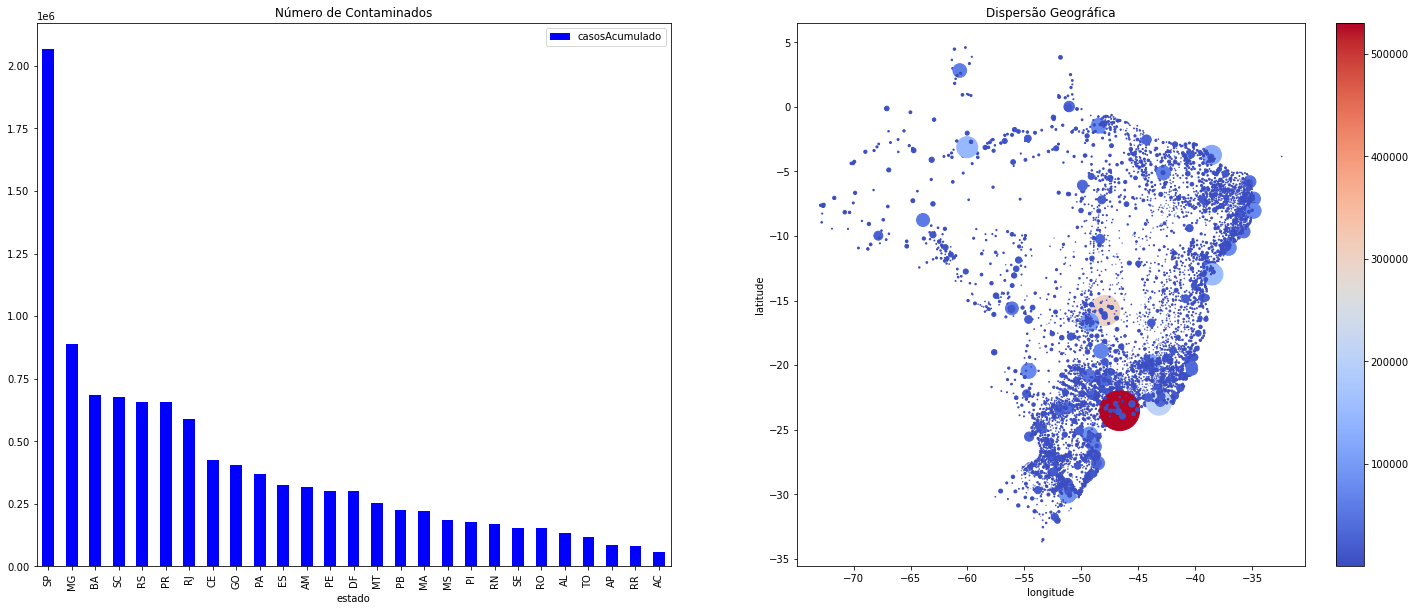

In [15]:
#Gráficos com a quantidade de contamidados por estado e município
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25,10))
dft[['casosAcumulado']].sort_values('casosAcumulado', ascending=False).plot(kind='bar', color='b', ax=ax1)
ax1.set_title('Número de Contaminados')
df2.plot(kind='scatter',x='longitude', y='latitude',c=df2['casosAcumulado'],s= df2['casosAcumulado'] *0.003,cmap='coolwarm', ax=ax2)
ax2.set_title('Dispersão Geográfica');

Vemos São Paulo também com o maior número de óbitos por conta da grande quantidade de contaminados. É importante observar que, embora o estado do Rio de Janeiro seja o sétimo em número de contaminados, ele aparece em segundo quando se trata de óbitos.

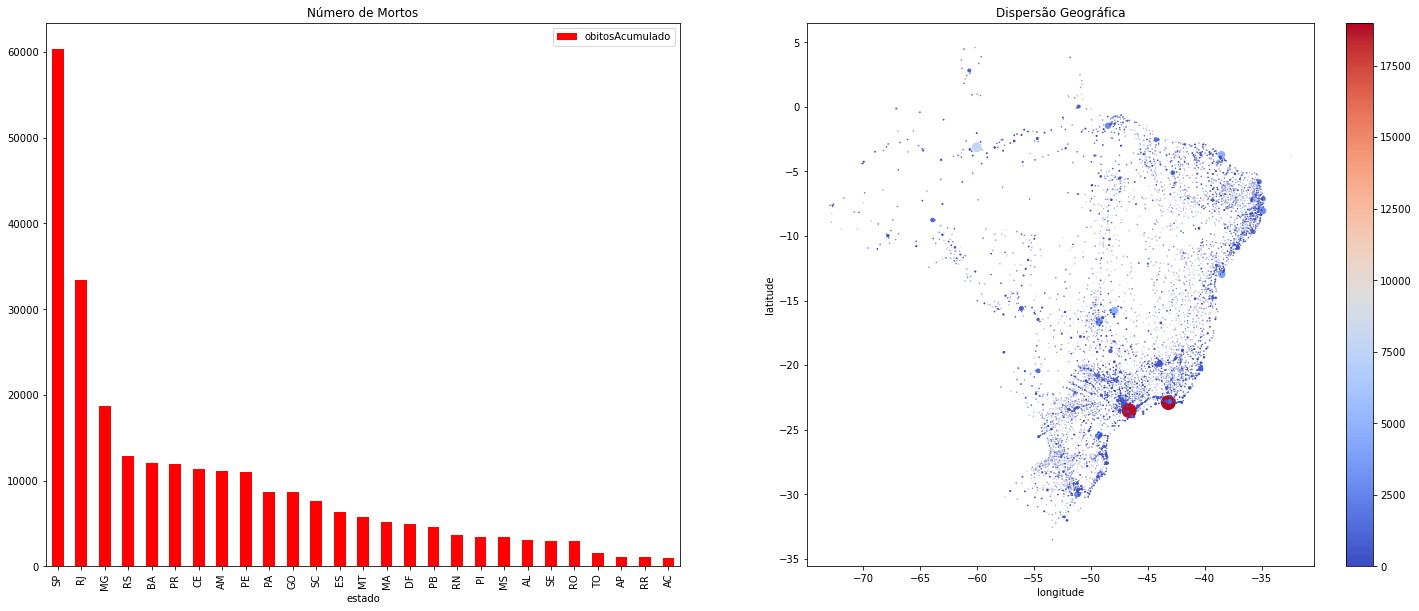

In [16]:
#Gráficos com a quantidade de obitos por estado e município
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25,10))
dft[['obitosAcumulado']].sort_values('obitosAcumulado', ascending=False).plot(kind='bar', color='r', ax=ax1)
ax1.set_title('Número de Mortos')
df2.plot(kind='scatter',x='longitude', y='latitude',c=df2['obitosAcumulado'],s= df2['obitosAcumulado'] *0.01,cmap='coolwarm', ax=ax2)
ax2.set_title('Dispersão Geográfica');

O estado que mais teve parte de sua população contaminada foi Roraima, aproximadamente 13%. Já São Paulo, um dos últimos, aproximadamente 4% de sua população foi acometida. O Rio por sua vez detentor do maior número de óbitos, teve menos de 3% de sua população contaminada.

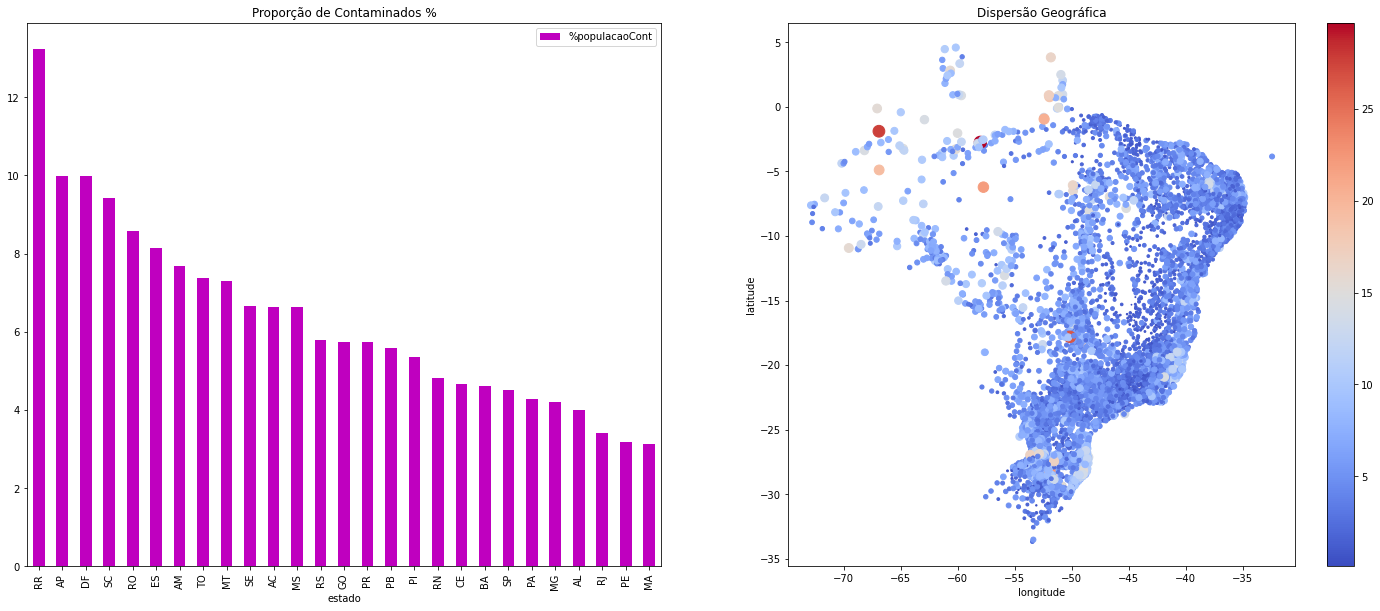

In [17]:
#Gráficos com a porcentagem de contaminados por estado e município
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25,10))
dft[['%populacaoCont']].sort_values('%populacaoCont', ascending=False).plot(kind='bar', color='m', ax=ax1)
ax1.set_title('Proporção de Contaminados %')
df2.plot(kind='scatter',x='longitude', y='latitude',c=df2['%populacaoCont'],s= df2['%populacaoCont'] *5,cmap='coolwarm', ax=ax2)
ax2.set_title('Dispersão Geográfica');

Corroborando as informações dos gráficos anteriores, o Rio possui a maior porcentagem de seus contaminados mortos. 

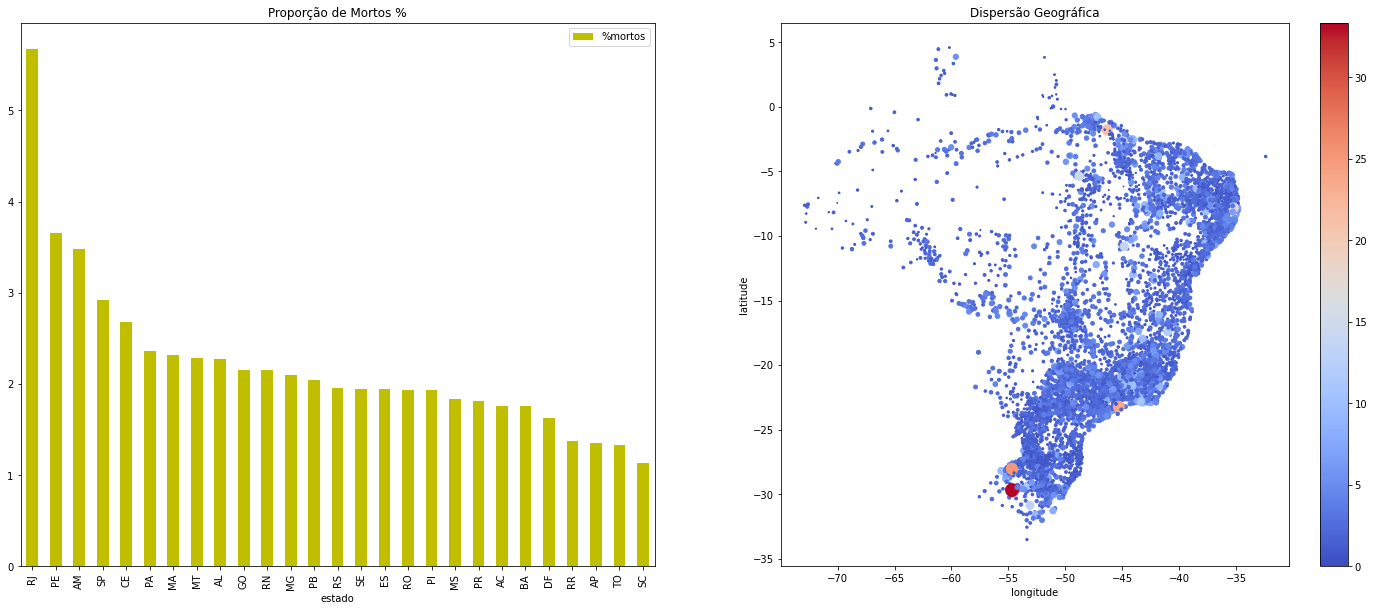

In [18]:
#Gráficos com a porcentagem de mortos por estado e município
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25,10))
dft[['%mortos']].sort_values('%mortos', ascending=False).plot(kind='bar', color='y', ax=ax1)
ax1.set_title('Proporção de Mortos %')
df2.plot(kind='scatter',x='longitude', y='latitude',c=df2['%mortos'],s= df2['%mortos'] *5,cmap='coolwarm', ax=ax2)
ax2.set_title('Dispersão Geográfica');